In [10]:
!pip install xgboost


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [11]:
!pip install lightgbm


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline

import seaborn as sns
df = sns.load_dataset('titanic').copy()

y = df['survived'].astype(int)
X = df.drop(columns=['survived'])

num_feats = ['age','fare','sibsp','parch', 'pclass']
cat_feats = ['sex', 'embarked','class','who','adult_male','alone']

In [13]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [14]:
numeric_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler(with_mean=False))
])

categorical_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocess = ColumnTransformer([
    ('num', numeric_pipe, num_feats),
    ('cat', categorical_pipe, cat_feats)
],
                               remainder='drop'
                               )

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [16]:
models = {
    'LogReg': LogisticRegression(max_iter=2000, n_jobs=None),
    'RandomForest': RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_leaf=2, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=42),
    'XGBoost': XGBClassifier(
        n_estimators=800,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1

    ),
    'LightGBM': LGBMClassifier(
        objective='binary',
        n_estimators=1500,
        learning_rate=0.1,
        num_leaves=63,
        max_bin=500,
        min_child_samples=10,
        min_child_weight=1e-4,
        min_split_gain=0.0,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        force_row_wise=True,
        class_weight=None,
        random_state=42,
        n_jobs=-1

    )
}

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'logloss':'neg_log_loss',
    'accuracy':'accuracy',
    'roc_auc':'roc_auc'
}

cv_results = []

for name, clf in models.items():
  pipe = Pipeline([
      ('prep',preprocess),
      ('clf',clf)
  ])

  cv = cross_validate(pipe, X, y, cv=skf, scoring=scoring, n_jobs=-1, return_train_score=False)
  cv_results.append({
      'model':name,
      'logloss_mean': -cv['test_logloss'].mean(),
      'logloss_std':cv['test_logloss'].std(),
      'roc_auc_mean': cv['test_roc_auc'].mean(),
      'accuracy_mean': cv['test_accuracy'].mean()
  })

cv_table = pd.DataFrame(cv_results).sort_values('logloss_mean')
cv_table

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

[LightGBM] [Warning] feature_fractio

,model,logloss_mean,logloss_std,roc_auc_mean,accuracy_mean
1,RandomForest,0.406291,0.024467,0.884683,0.841755
0,LogReg,0.423345,0.021079,0.865971,0.822666
3,XGBoost,0.467421,0.055887,0.876057,0.817049
2,GradientBoosting,0.483996,0.064597,0.877195,0.817011
4,LightGBM,1.218876,0.209318,0.854860,0.802436


In [18]:
df['survived'].mean()

0.3838383838383838

# Resampling

In [19]:
df = pd.read_csv('credit_dataset.csv')

In [20]:
df = df.iloc[:,1:]

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25134 entries, 0 to 25133
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              25134 non-null  int64  
 1   GENDER          25134 non-null  object 
 2   CAR             25134 non-null  object 
 3   REALITY         25134 non-null  object 
 4   NO_OF_CHILD     25134 non-null  int64  
 5   INCOME          25134 non-null  float64
 6   INCOME_TYPE     25134 non-null  object 
 7   EDUCATION_TYPE  25134 non-null  object 
 8   FAMILY_TYPE     25134 non-null  object 
 9   HOUSE_TYPE      25134 non-null  object 
 10  FLAG_MOBIL      25134 non-null  int64  
 11  WORK_PHONE      25134 non-null  int64  
 12  PHONE           25134 non-null  int64  
 13  E_MAIL          25134 non-null  int64  
 14  FAMILY SIZE     25134 non-null  float64
 15  BEGIN_MONTH     25134 non-null  int64  
 16  AGE             25134 non-null  int64  
 17  YEARS_EMPLOYED  25134 non-null 

In [22]:
df['TARGET'].mean()

0.01679000557014403

In [23]:
minority = df[df['TARGET']==1]
majority = df[df['TARGET']==0]

<Axes: xlabel='INCOME', ylabel='Count'>

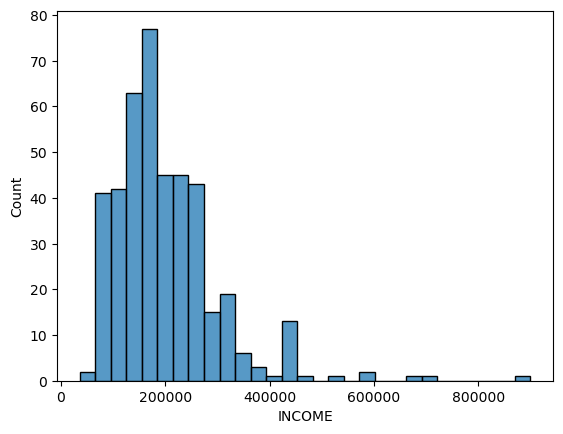

In [24]:
sns.histplot(minority['INCOME'])


<Axes: xlabel='INCOME', ylabel='Count'>

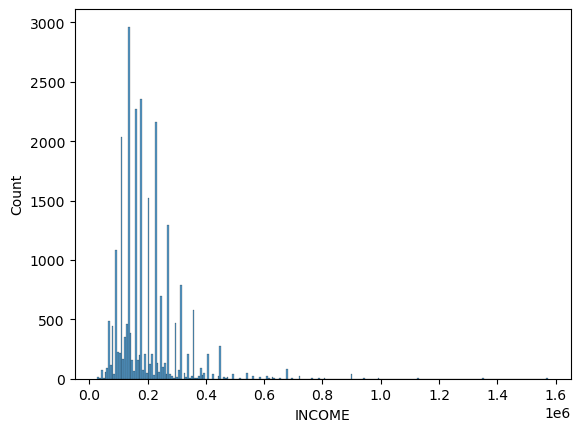

In [25]:
sns.histplot(majority['INCOME'])

In [26]:
minority.groupby('EDUCATION_TYPE')['ID'].count()/len(minority)

EDUCATION_TYPE
Higher education                 0.303318
Incomplete higher                0.049763
Lower secondary                  0.014218
Secondary / secondary special    0.632701
Name: ID, dtype: float64

In [27]:
majority.groupby('EDUCATION_TYPE')['ID'].count()/len(majority)

EDUCATION_TYPE
Academic degree                  0.000567
Higher education                 0.283425
Incomplete higher                0.039333
Lower secondary                  0.007324
Secondary / secondary special    0.669351
Name: ID, dtype: float64

In [28]:
pip install imblearn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
from imblearn.over_sampling import RandomOverSampler

In [30]:
from imblearn.under_sampling import RandomUnderSampler

In [31]:
from imblearn.over_sampling import SMOTE

In [32]:
X.dropna(inplace=True)

In [33]:
y= y.loc[X.index.to_list()]

In [34]:
X = X[['pclass','age','fare']]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
smote = SMOTE(random_state=42, k_neighbors=5)

In [37]:
X_res, y_res = smote.fit_resample(X_train, y_train)

In [38]:
X_res

,pclass,age,fare
0,1,45.500000,28.500000
1,1,29.000000,66.600000
2,2,3.000000,26.000000
3,3,25.000000,7.650000
4,1,37.000000,52.554200
...,...,...,...
193,1,40.226192,55.994611
194,1,20.969774,51.596599
195,1,5.422414,159.756950
196,1,16.335857,151.550000


In [39]:
X

,pclass,age,fare
1,1,38.0,71.2833
3,1,35.0,53.1000
6,1,54.0,51.8625
10,3,4.0,16.7000
11,1,58.0,26.5500
...,...,...,...
871,1,47.0,52.5542
872,1,33.0,5.0000
879,1,56.0,83.1583
887,1,19.0,30.0000


In [40]:
df.drop(columns=['ID'], inplace=True)

In [41]:
df.groupby("TARGET")['GENDER'].count()/len(df)

TARGET
0    0.98321
1    0.01679
Name: GENDER, dtype: float64

In [42]:
df.head(1)

,GENDER,CAR,REALITY,NO_OF_CHILD,INCOME,INCOME_TYPE,EDUCATION_TYPE,FAMILY_TYPE,HOUSE_TYPE,FLAG_MOBIL,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,AGE,YEARS_EMPLOYED,TARGET
0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,2.0,29,59,3,0


In [43]:
# creating pipelines
num_feats = ['INCOME', 'NO_OF_CHILD', 'FAMILY SIZE', 'BEGIN_MONTH', 'AGE', 'YEARS_EMPLOYED']
cat_feats = ['GENDER', 'CAR', 'REALITY', 'INCOME_TYPE', 'EDUCATION_TYPE', 'FAMILY_TYPE', 'HOUSE_TYPE']

In [44]:
# pipelines
numeric = Pipeline([('imputer', SimpleImputer(strategy='median')),
                    ['scale', StandardScaler(with_mean=False)]])
categorical = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),
                        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

prep = ColumnTransformer([('num',numeric, num_feats),('cat',categorical, cat_feats)], remainder='drop') # column transformation

In [45]:
# define inputs and output
X = df.drop(columns=['TARGET'])
y = df['TARGET']

In [46]:
# building some baseline models
# first split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# because of data set imbalance, just going to check counts
y_train.groupby(y_train).count()/len(y_train)
# checking if my training data is representative

TARGET
0    0.983289
1    0.016711
Name: TARGET, dtype: float64

In [48]:
y_test.groupby(y_test).count()/len(y_test) # seems like a fair split so may not have to use stratified sampling

TARGET
0    0.982892
1    0.017108
Name: TARGET, dtype: float64

In [49]:
# builing some baseline models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [50]:
lr = Pipeline([
    ('prep',prep),
    ('lr', LogisticRegression(max_iter=2000, n_jobs=None, random_state=42))
])

rf = Pipeline([
    ('prep',prep),
    ('rf', RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=42))
])

gb = Pipeline([
    ('prep',prep),
    ('gb', GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=42))
])

xgb = Pipeline([
    ('prep',prep),
    ('xgb', XGBClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

lgbm = Pipeline([
    ('prep',prep),
    ('lgbm', LGBMClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

In [51]:
models = {'LR':lr,'RF':rf,'GB':gb,'XGB':xgb,'LGBM':lgbm}

In [52]:
# cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {'accuracy':'accuracy', 'roc_auc':'roc_auc', 'f1':'f1', 'precision':'precision', 'recall':'recall', 'neg_log_loss':'neg_log_loss'}

In [53]:
cv_rows = []

for name, pipe in models.items():
  res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
  cv_rows.append({
      'model':name,
      'acc_mean': res['test_accuracy'].mean(),
      'auc_mean': res['test_roc_auc'].mean(),
      'f1_mean': res['test_f1'].mean(),
      'prec_mean': res['test_precision'].mean(),
      'recall_mean': res['test_recall'].mean(),
      'logloss_mean': -res['test_neg_log_loss'].mean()
  })

cv_df = pd.DataFrame(cv_rows).sort_values("auc_mean", ascending=False)
cv_df

[LightGBM] [Info] Number of positive: 268, number of negative: 15817
[LightGBM] [Info] Number of positive: 269, number of negative: 15817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 16085, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016661 -> initscore=-4.077854
[LightGBM] [Info] Start training from score -4.077854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 16086, number of used features: 30
[LightGBM] [Info] [binar

,model,acc_mean,auc_mean,f1_mean,prec_mean,recall_mean,logloss_mean
1,RF,0.983339,0.800181,0.261315,0.500477,0.178358,0.091890
3,XGB,0.982494,0.779875,0.224785,0.441905,0.151668,0.093189
2,GB,0.983190,0.762019,0.152823,0.486887,0.092098,0.074602
4,LGBM,0.982494,0.756430,0.230457,0.435386,0.157638,0.167210
0,LR,0.983737,0.670928,0.051855,1.000000,0.026734,0.080369


LGBM is worse compared to the other models
The other models aren't overly confident either

In [54]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [55]:
# PIPELINES WITH RESAMPLING

lr_under = Pipeline([
    ('prep',prep),
    ('under', RandomUnderSampler(random_state=42)),
    ('lr', LogisticRegression(max_iter=2000, n_jobs=None, random_state=42))
])

lr_over = Pipeline([
    ('prep',prep),
    ('over', RandomOverSampler(random_state=42)),
    ('lr', LogisticRegression(max_iter=2000, n_jobs=None, random_state=42))
])

lr_smote = Pipeline([
    ('prep',prep),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(max_iter=2000, n_jobs=None, random_state=42))
])

rf_under = Pipeline([
    ('prep',prep),
    ('under', RandomUnderSampler(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=42))
])

rf_over = Pipeline([
    ('prep',prep),
    ('over', RandomOverSampler(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=42))
])

rf_smote = Pipeline([
    ('prep',prep),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=42))
])

gb_under = Pipeline([
    ('prep',prep),
    ('under', RandomUnderSampler(random_state=42)),
    ('gb', GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=42))
])

gb_over = Pipeline([
    ('prep',prep),
    ('over', RandomOverSampler(random_state=42)),
    ('gb', GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=42))
])

gb_smote = Pipeline([
    ('prep',prep),
    ('smote', SMOTE(random_state=42)),
    ('gb', GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=42))
])

xgb_under = Pipeline([
    ('prep',prep),
    ('under', RandomUnderSampler(random_state=42)),
    ('xgb', XGBClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

xgb_over = Pipeline([
    ('prep',prep),
    ('over', RandomOverSampler(random_state=42)),
    ('xgb', XGBClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

xgb_smote = Pipeline([
    ('prep',prep),
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

lgbm_under = Pipeline([
    ('prep',prep),
    ('under', RandomUnderSampler(random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

lgbm_over = Pipeline([
    ('prep',prep),
    ('over', RandomOverSampler(random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

lgbm_smote = Pipeline([
    ('prep',prep),
    ('smote', SMOTE(random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

# scale position weight parameter (gradient boost does not have class weight)
lr_weighted = Pipeline([
    ('prep',prep),
    ('lr', LogisticRegression(max_iter=2000, class_weight = 'balanced', n_jobs=None, random_state=42))
])

rf_weighted = Pipeline([
    ('prep',prep),
    ('rf', RandomForestClassifier(n_estimators=1000, class_weight='balanced',max_depth=None, random_state=42))
])

xgb_weighted = Pipeline([
    ('prep',prep),
    ('xgb', XGBClassifier(n_estimators=1000, learning_rate=0.1, scale_pos_weight=(len(y_train[y_train==0])/len(y_train[y_train==1])), random_state=42))
])

lgbm_weighted = Pipeline([
    ('prep',prep),
    ('lgbm', LGBMClassifier(n_estimators=1000, class_weight='balanced',learning_rate=0.1, random_state=42))
])


In [56]:
models = {'LR':lr,'RF':rf,'GB':gb,'XGB':xgb,'LGBM':lgbm, 
          'lr_weighted':lr_weighted, 'rf_weighted':rf_weighted, 
          'xgb_weighted':xgb_weighted, 'lgbm_weighted':lgbm_weighted,
          'lr_under':lr_under, 'lr_over':lr_over, 'lr_smote':lr_smote,
          'rf_under':rf_under, 'rf_over':rf_over, 'rf_smote':rf_smote,
          'gb_under':gb_under, 'gb_over':gb_over, 'gb_smote':gb_smote,
          'xgb_under':xgb_under, 'xgb_over':xgb_over, 'xgb_smote':xgb_smote,
          'lgbm_under':lgbm_under, 'lgbm_over':lgbm_over, 'lgbm_smote':lgbm_smote
          }

Risk of resampling is overfitting
- resampling doesn't lead to improved performance on every model
- resampling is not a silver bullet
- collect more data points or more features

**SHAP & LIME**

In [57]:
import shap

In [58]:
# feature names from the pipelines

def get_final_feature_names(prep, num_feats, cat_feats):
  # original names
  num_out = np.array(num_feats, dtype=object)

  #cat names
  cat_trans = prep.named_transformers_['cat']
  ohe = cat_trans.named_steps['onehot']
  cat_out = ohe.get_feature_names_out(cat_feats)
  return np.concatenate([num_out, cat_out])

In [59]:
# transform X using only the prep step

def transform_X(pipeline, X_df):
  prep = pipeline.named_steps['prep']
  X_prep = prep.transform(X_df)
  # ensures dense matrix
  if hasattr(Xp, "toarray"):
    Xp = Xp.toarray()
  return Xp

In [60]:
# get the estimator

def get_estimator(pipe):
  for name, step in reversed(pipe.named_steps.items()):
    if hasattr(step, 'predict'):
      return step
    raise RuntimeError('No estimator found')

In [62]:
# lgbm_smote

best_pipe = models['lr_under']
best_pipe.fit(X_train, y_train)

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'RandomUnderSampler(random_state=42)' (type <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'>) doesn't

In [ ]:
prep = best_pipe.named_steps['prep']

In [ ]:
feature_names = get_final_feature_names(prep, num_feats, cat_feats)

In [ ]:
# transform X using only the prep step

def transform_X(pipeline, X_df):
  prep = pipeline.named_steps['prep']
  X_prep = prep.transform(X_df)
  # ensures dense matrix
  if hasattr(Xp, "toarray"):
    X_prep = Xp.toarray()
  return X_prep

In [ ]:
# transform X using only the prep step

def transform_X(pipeline, X_df):
  prep = pipeline.named_steps['prep']
  X_prep = prep.transform(X_df)
  # ensures dense matrix
  if hasattr(X_prep, "toarray"):
    X_prep = X_prep.toarray()
  return X_prep

In [ ]:
background = shap.sample(Xp_train, 100) # kernel explainer is for knn (any model that is not a linear model or a tree based model)

https://shap.readthedocs.io/en/latest/api_examples.html#explainers 

In [63]:
est = get_estimator(best_pipe)

In [64]:
model_name = est.__class__.__name__.lower()

In [65]:
pos_idx = 1 if hasattr(est, "predict_proba") else None

In [ ]:
if "forest" in model_name or "xgb" in model_name or 'lgbm' in model_name:
  explainer = shap.TreeExplainer(est, data=background, feature_perturbation="interventional")
  shap_values = explainer.shap_values(Xp_train)
  if isinstance(shap_values, list):
    shap_values = shap_values[pos_idx] # use only when training your model to understand model interpretability or post-hoc

In [ ]:
shap.plots.bar(shap_values.abs.mean(0))

In [ ]:
#global plots

shap.summary_plot(shap_values, Xp_train, feature_names=feature_names, show=True)

shap.summary_plot(shap_values, Xp_train, feature_names=feature_names, plot_type="bar", show=True)

In [ ]:
# Local explanation

i = 0  
xp = Xp_train[i:i+1]
shap.force_plot(explainer.expected_value, shap_values[i], xp, feature_names=feature_names, matplotlib=True)